In [1]:
import xarray as xr
import gsw

# Importa funções para criar a Equação de Estado
from neutralocean.eos import make_eos, make_eos_s_t

# Importa funções para calcular várias superfícies aproximadamente neutras
from neutralocean.surface import potential_surf, anomaly_surf, omega_surf

# Importa funções para construir uma grade retangular e converter dados de borda em mapas
from neutralocean.grid.rectilinear import build_grid, edgedata_to_maps

#Dados de temperatura e salinidade do WOA
temp = xr.open_dataset("woa18_decav81B0_t00_01.nc", decode_times=False)
sal = xr.open_dataset("woa18_decav81B0_s00_01.nc", decode_times=False)

press= gsw.p_from_z(-temp.depth, 0)
sal = gsw.SA_from_SP(sal.s_an, press, sal.lon, sal.lat)
temp = gsw.CT_from_t(sal, temp.t_an, press)

Seleciona as variáveis

In [4]:
T = temp
S = sal

In [5]:
#Dados para o grid. Tempo, profundidade, longitude e latitude, importante é longitude(ni) e latitude(nj)
t, nk, ni, nj = S.shape

In [6]:
#Pega os valores de profundidade
Z = S.depth.values

### Constrói o grid, apenas com valores ni e nj.  (False, True) depende do formato do grid.
Email do geoff: if your data is arranged with latitude as the first dimension and longitude as the second dimension (and depth as the third dimension), then this would be (False, True). In the OCCA example, we have S.shape = (360, 160, 50), which is (longitude, latitude, depth), so g["wrap"] is (True, False).


In [7]:
grid = build_grid(
    (ni, nj), (False, True))

#Cria os dados da minha superfície de densidade neutra.
s--> Salinidade associada a ela, t--> Temperatura associada a ela, z--> Profundidade associada a ela. d --> dados gerais da superfície

In [8]:
s, t, z, d = potential_surf(
    S,
    T,
    Z,
    grid=grid,
    eos="jmd95",
    grav=9.81,
    rho_c=1027.5,
    vert_dim="depth",
    ref=0.0,
    isoval=1027.2,
)

potential done |       32417 wet casts | RMS(ϵ) = 1.26997816e-03  | 8.168 sec


In [13]:
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'
area1 = gpd.read_file('50S_20S.kml', driver="KML")
area2 = gpd.read_file('25S_20N.kml', driver="KML")

C:\Users\gabri\AppData\Local\Temp\ipykernel_27120\3360235231.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_area1 = area1.geometry.centroid
C:\Users\gabri\AppData\Local\Temp\ipykernel_27120\3360235231.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_area2 = area2.geometry.centroid


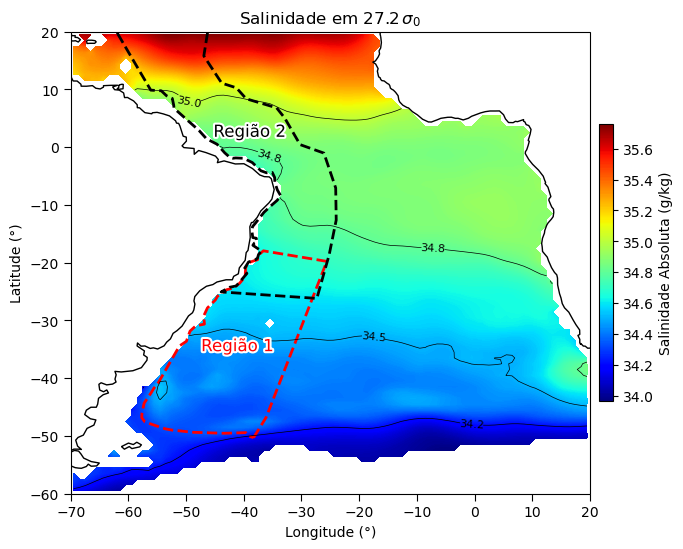

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import fiona
import numpy as np
import matplotlib.patheffects as PathEffects  # Importar para adicionar efeitos ao texto

# Configuração para suportar arquivos KML
fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Carregar as áreas de interesse dos arquivos KML
area1 = gpd.read_file('50S_20S.kml', driver="KML")
area2 = gpd.read_file('25S_20N.kml', driver="KML")

# Definir os limites do Brasil em termos de latitude e longitude
lat_min, lat_max = -60, 20.0  # Aproximadamente a extensão do Brasil
lon_min, lon_max = -70, 20.0

# Cortar o DataArray para a região do Brasil
data_brasil = s.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Criar um plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Adicionar linhas costeiras e outros recursos geográficos
ax.add_feature(cfeature.COASTLINE)

# Adicionar ticks nos eixos
ax.set_xticks(np.arange(lon_min, lon_max + 10, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 10, 10), crs=ccrs.PlateCarree())

# Customizar a aparência dos ticks
ax.tick_params(axis='both', which='both', length=5, color='black', direction='out', labelsize=10)

# Plotar os dados com a colorbar personalizada
contour = data_brasil.plot.contourf(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap='jet', 
    add_colorbar=False,  # Não adiciona a colorbar automaticamente
    levels=500
)

# Adicionar colorbar manualmente
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.01, shrink=0.6)
cbar.set_label('Salinidade Absoluta (g/kg)')  # Define o título da colorbar
# Definir os ticks da colorbar
cbar_ticks = np.arange(34, 35.6, 0.2)  # Ticks de 34 a 35.6 com intervalo de 0.4
cbar.set_ticks(cbar_ticks)  # Define os ticks na colorbar
cbar.minorticks_off()

# Adicionar as linhas de contorno
contour = data_brasil.plot.contour(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    colors='black',  # Cor das linhas de contorno
    linewidths=0.5,  # Largura das linhas de contorno
    levels=[34.2, 34.5, 34.8, 35]  # Níveis de contorno
)

# Adicionar rótulos aos contornos
ax.clabel(contour, inline=True, fontsize=8, fmt='%.1f')

ax.set_ylabel("Latitude (°)")
ax.set_xlabel("Longitude (°)")

# Plotar as áreas dos arquivos KML
area1.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, transform=ccrs.PlateCarree(), linestyle='--')
area2.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, transform=ccrs.PlateCarree(), linestyle='--')

# Calcular o centróide das áreas
centroid_area1 = area1.geometry.centroid
centroid_area2 = area2.geometry.centroid

# Adicionar texto ao centro das regiões com borda branca
txt1 = ax.text(centroid_area1.x, centroid_area1.y, 'Região 1', transform=ccrs.PlateCarree(), fontsize=12, ha='center', color='red')
txt1.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])  # Adicionar borda branca

txt2 = ax.text(centroid_area2.x, centroid_area2.y+4, 'Região 2', transform=ccrs.PlateCarree(), fontsize=12, ha='center', color='black')
txt2.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])  # Adicionar borda branca

# Adicionar título e mostrar o plot
plt.title(r"Salinidade em $27.2 \, \sigma_0$")
plt.savefig("Plot_Salinidade_Mapa.png")
plt.show()
